# Mercari Price Suggestion Challenge Data Analysis & Preparation

This notebook is for analysis and initial preprocessing.

## Imports and Inits

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pdb
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from tqdm import tqdm_notebook as tqdm
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [4]:
from args import args
vars(args)

{'path': PosixPath('data'),
 'workdir': PosixPath('data/workdir'),
 'train_tsv': PosixPath('data/train.tsv'),
 'test_tsv': PosixPath('data/test.tsv'),
 'test2_tsv': PosixPath('data/test_stg2.tsv'),
 'modeldir': PosixPath('data/workdir/models'),
 'figdir': PosixPath('data/workdir/figures')}

In [6]:
train_df = pd.read_csv(args.train_tsv, sep='\t')
test_df = pd.read_csv(args.test_tsv, sep='\t')
test2_df = pd.read_csv(args.test2_tsv, sep='\t')
train_df.shape, test_df.shape, test2_df.shape

cols = ['name', 'item_condition_id', 'category_name', 'brand_name', 'shipping', 'item_description']
all_df = pd.concat([train_df[cols], test_df[cols], test2_df[cols]], axis=0)
all_df.reset_index(drop=True, inplace=True)
all_df.shape

(5636619, 6)

In [7]:
save = True

## Target Variable: Price

Remove prices below `$3` as Merari does not allow postings below `$3` which makes it an error. Also, replace the price with its `log1p`

In [8]:
train_df = train_df[(train_df['price'] > 3) & (train_df['price'] < 2000)].reset_index(drop=True)
train_df['price'] = np.log1p(train_df['price'])

In [9]:
def thous(x, pos):
  return f'{(x*1e-3):1.1f}k'

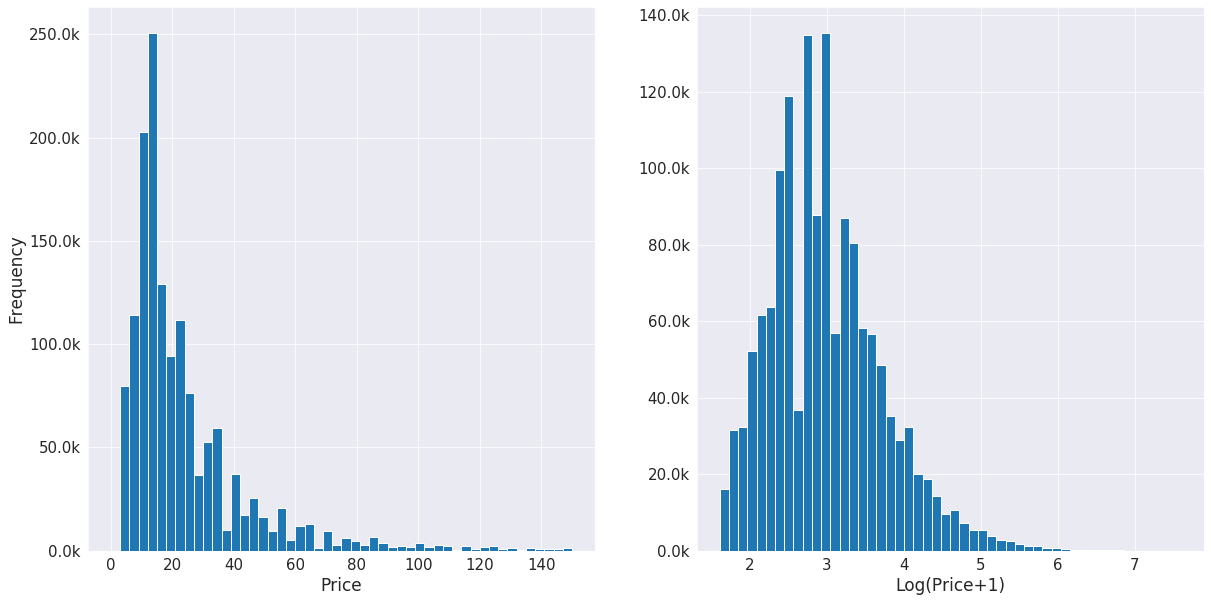

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
np.expm1(train_df['price']).plot.hist(bins=50, ax=ax[0], edgecolor='white', range=[0, 150])
ax[0].set_xlabel('Price', fontsize=17)
ax[0].set_ylabel('Frequency', fontsize=17)
formatter = FuncFormatter(thous)
ax[0].yaxis.set_major_formatter(formatter)
ax[0].tick_params(labelsize=15)

train_df['price'].plot.hist(bins=50, ax=ax[1], edgecolor='white')
ax[1].set_xlabel('Log(Price+1)', fontsize=17)
ax[1].set_ylabel('')
ax[1].yaxis.set_major_formatter(formatter)
ax[1].tick_params(labelsize=15)

if save:
  fig.savefig(args.figdir/'price_dist.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

## Shipping

If `shipping` is not available it is assumed to be paid by the buyer.

In [11]:
train_df['shipping'].fillna(0, inplace=True)
test_df['shipping'].fillna(0, inplace=True)
test2_df['shipping'].fillna(0, inplace=True)
all_df['shipping'].fillna(0, inplace=True)

The shipping cost burden is decently splitted between sellers and buyers with more than half of the items' shipping fees are paid by the sellers (55%). In addition, the average price paid by users who have to pay for shipping fees is lower than those that don't require additional shipping cost. This matches with our perception that the sellers need a lower price to compensate for the additional shipping.

In [12]:
np.round((all_df['shipping'].value_counts()/len(all_df)) * 100, 1)

0    55.2
1    44.8
Name: shipping, dtype: float64

In [13]:
seller_ship = train_df.loc[train_df['shipping'] == 1, 'price']
buyer_ship = train_df.loc[train_df['shipping'] == 0, 'price']

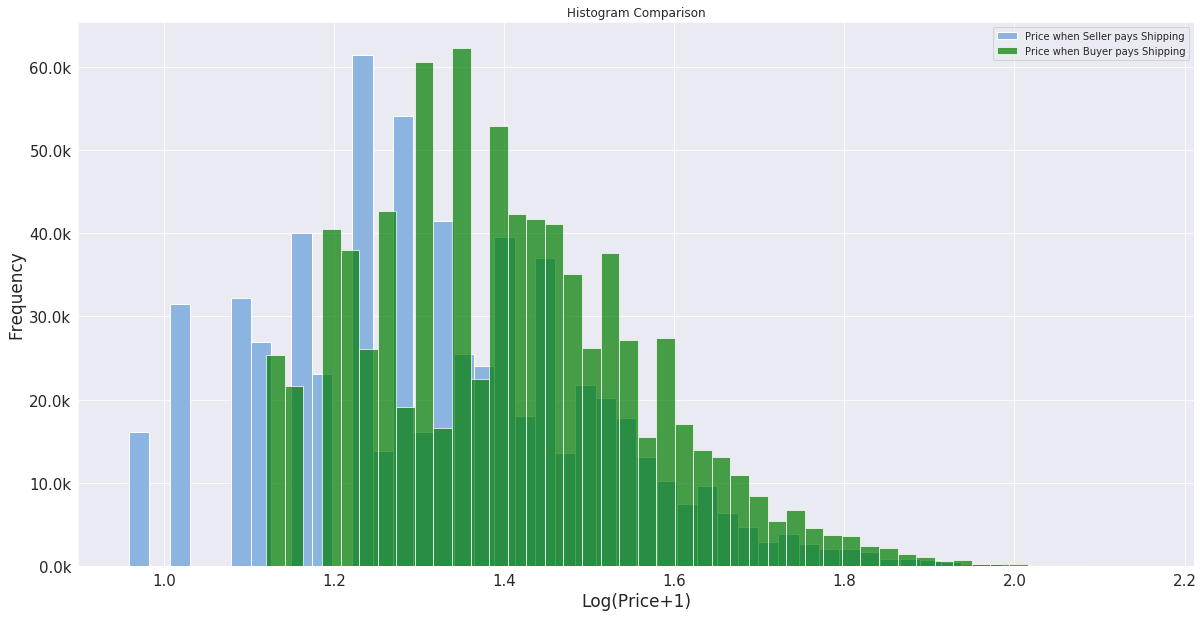

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log1p(seller_ship), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log1p(buyer_ship), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
ax.set_xlabel('Log(Price+1)', fontsize=17)
ax.set_ylabel('Frequency', fontsize=17)
ax.legend()
formatter = FuncFormatter(thous)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(labelsize=15)

if save:
  fig.savefig(args.figdir/'price_dist_by_shipping.pdf', dpi=300, bbox_inches='tight', pad_inches=0) 

## Item Category

There are about **1,287** unique categories but among each of them, we will always see a main category firstly, followed by two more particular subcategories (e.g. Beauty/Makeup/Face or Lips). In adidition, there are about 6,327 items that do not have a category labels. Let's split the categories into three different columns. We will see later that this information is actually quite important from the seller's point of view and how we handle the missing information in the `brand_name` column will impact the model's prediction. 

In [15]:
train_df['category_name'].fillna(value='missing/missing/missing', inplace=True)
train_df['main_cat'],train_df['sub_cat1'],train_df['sub_cat2'] = zip(*train_df['category_name'].apply(lambda text: text.split('/')))

test_df['category_name'].fillna(value='missing/missing/missing', inplace=True)
test_df['main_cat'],test_df['sub_cat1'],test_df['sub_cat2'] = zip(*test_df['category_name'].apply(lambda text: text.split('/')))

test2_df['category_name'].fillna(value='missing/missing/missing', inplace=True)
test2_df['main_cat'],test2_df['sub_cat1'],test2_df['sub_cat2'] = zip(*test2_df['category_name'].apply(lambda text: text.split('/')))

all_df['category_name'].fillna(value='missing/missing/missing', inplace=True)
all_df['main_cat'],all_df['sub_cat1'],all_df['sub_cat2'] = zip(*all_df['category_name'].apply(lambda text: text.split('/')))

In [16]:
print("Full Dataset")
print(f"There are {all_df['category_name'].nunique()} unique values in the category column.")
print(f"There are {len(all_df[all_df['main_cat'] == 'missing'])} items that do not have a label.")
print(f"There are {all_df['main_cat'].nunique()} unique main categories.")
print(f"There are {all_df['sub_cat1'].nunique()} unique first sub-categories.")
print(f"There are {all_df['sub_cat2'].nunique()} unique second sub-categories.")

Full Dataset
There are 1354 unique values in the category column.
There are 24218 items that do not have a label.
There are 11 unique main categories.
There are 114 unique first sub-categories.
There are 905 unique second sub-categories.


In [17]:
print("Training Dataset")
print(f"There are {train_df['category_name'].nunique()} unique values in the category column.")
print(f"There are {len(train_df[train_df['main_cat'] == 'missing_cat'])} items that do not have a label.")
print(f"There are {train_df['main_cat'].nunique()} unique main categories.")
print(f"There are {train_df['sub_cat1'].nunique()} unique first sub-categories.")
print(f"There are {train_df['sub_cat2'].nunique()} unique second sub-categories.")

Training Dataset
There are 1288 unique values in the category column.
There are 0 items that do not have a label.
There are 11 unique main categories.
There are 114 unique first sub-categories.
There are 871 unique second sub-categories.


In [18]:
# TOP 5 RAW CATEGORIES
all_df['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    227489
Women/Tops & Blouses/T-Shirts                     176416
Beauty/Makeup/Face                                130406
Beauty/Makeup/Lips                                113683
Electronics/Video Games & Consoles/Games          101755
Name: category_name, dtype: int64

In [19]:
# TOP 5 RAW CATEGORIES
train_df['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60105
Women/Tops & Blouses/T-Shirts                     46052
Beauty/Makeup/Face                                33994
Beauty/Makeup/Lips                                29373
Electronics/Video Games & Consoles/Games          26409
Name: category_name, dtype: int64

In [20]:
x = all_df['main_cat'].value_counts().index.values.astype('str')
y = all_df['main_cat'].value_counts().values
pct = [f"{(v * 100):0.2f}%" for v in (y/len(all_df))]

trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(yaxis = dict(title='Count'), xaxis = dict(title='Main Category'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [21]:
x = all_df['sub_cat1'].value_counts().index.values.astype('str')[:15]
y = all_df['sub_cat1'].value_counts().values[:15]
pct = [f"{(v * 100):0.2f}%" for v in (y/len(all_df))][:15]

trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(yaxis = dict(title='Count'), xaxis = dict(title='SubCategory 1'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [22]:
x = all_df['sub_cat2'].value_counts().index.values.astype('str')[:15]
y = all_df['sub_cat2'].value_counts().values[:15]
pct = [f"{(v * 100):0.2f}%" for v in (y/len(all_df))][:15]

trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(yaxis = dict(title='Count'), xaxis = dict(title='SubCategory 2'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

## Brand Name

In [23]:
train_df['brand_name'].fillna('missing', inplace=True)
test_df['brand_name'].fillna('missing', inplace=True)
test2_df['brand_name'].fillna('missing', inplace=True)
all_df['brand_name'].fillna('missing', inplace=True)

In [24]:
print(f"There are {all_df['brand_name'].nunique()} unique brand names in the full dataset.")
print(f"There are {train_df['brand_name'].nunique()} unique brand names in the training dataset.")

There are 6312 unique brand names in the full dataset.
There are 4791 unique brand names in the training dataset.


In [25]:
x = all_df['brand_name'].value_counts().index.values.astype('str')[:15]
y = all_df['brand_name'].value_counts().values[:15]

In [26]:
trace1 = go.Bar(x=x, y=y, 
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(xaxis = dict(title='Brand Name'), yaxis = dict(title='Count'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

## Item Description

- Replace `NaN`s and "No description yet" with empty strings
- Merge `name` and `item_description`

In [27]:
train_df['item_description'].replace('No description yet', '', inplace=True)
train_df['text'] = train_df['name'] + '\n' + train_df['item_description']
train_df['text'].fillna('', inplace=True)

test_df['item_description'].replace('No description yet', '', inplace=True)
test_df['text'] = test_df['name'] + '\n' + test_df['item_description']
test_df['text'].fillna('', inplace=True)

test2_df['item_description'].replace('No description yet', '', inplace=True)
test2_df['text'] = test2_df['name'] + '\n' + test2_df['item_description']
test2_df['text'].fillna('', inplace=True)

all_df['item_description'].replace('No description yet', '', inplace=True)
all_df['text'] = test2_df['name'] + '\n' + test2_df['item_description']
all_df['text'].fillna('', inplace=True)

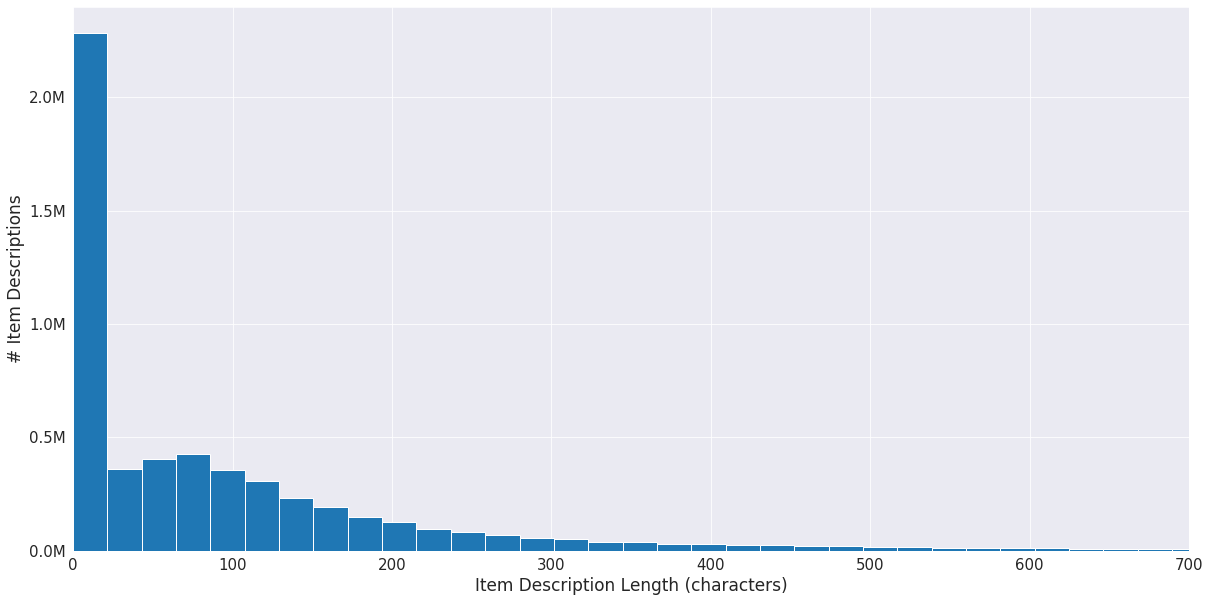

In [28]:
def millions(x, pos):
  return f'{(x*1e-6):1.1f}M'

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
all_df['text'].apply(len).plot.hist(bins=50, ax=ax, edgecolor='white')
ax.set_xlabel('Item Description Length (characters)', fontsize=17)
ax.set_ylabel('# Item Descriptions', fontsize=17)
ax.set_xlim(0, 700)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(labelsize=15)

if save:
  fig.savefig(args.figdir/'desc_len_dist.pdf', dpi=300, bbox_inches='tight', pad_inches=0) 

## Write to disk

In [29]:
train_df.to_csv(args.path/'train_df.csv', index=False)
test_df.to_csv(args.path/'test_df.csv', index=False)
test2_df.to_csv(args.path/'test2_df.csv', index=False)